# Using two spatial graphs

Some functions are using spatial graphs for two different purposes. Therefore two Graphs have to be passed. We will illustrate this case measuring building adjacency and mean interbuilding distance. 

In [1]:
import matplotlib.pyplot as plt
import momepy
import osmnx as ox
from libpysal import graph

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation. 

In [2]:
gdf = ox.features.features_from_place("Kahla, Germany", tags={"building": True})
buildings = ox.projection.project_gdf(gdf).reset_index(drop=True)

limit = momepy.buffered_limit(buildings)
tess = momepy.morphological_tessellation(buildings, clip=limit)
tessellation = tess.to_frame("geometry")

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/features.py:294: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


## Building adjacency

Building adjacency reflects how much buildings tend to join together into larger structures. It is calculated as a ratio of joined built-up structures captured by ``contiguity_graph`` and buildings within the neighborhood defined in ``neighborhood_graph``.

Let's get both.

In [3]:
# contiguity_graph
rook = graph.Graph.build_contiguity(buildings)

# neighborhood_graph
dist200 = graph.Graph.build_distance_band(buildings.centroid, 200)

In [4]:
buildings["adjacency"] = momepy.building_adjacency(
    contiguity_graph=rook, neighborhood_graph=dist200
)

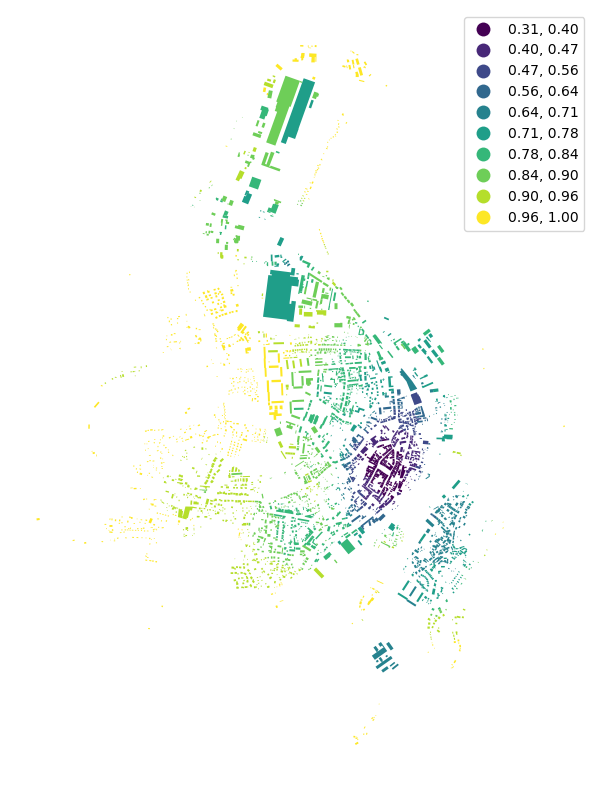

In [5]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(
    ax=ax,
    column="adjacency",
    legend=True,
    cmap="viridis",
    scheme="naturalbreaks",
    k=10,
)
ax.set_axis_off()
plt.show()

## Mean interbuilding distance

Mean interbuilding distance is similar to `neighbour_distance`, but it is calculated within vicinity defined by the order of contiguity.

In [6]:
queen_tess = graph.Graph.build_contiguity(tessellation, rook=False)

buildings["mean_ib_dist"] = momepy.mean_interbuilding_distance(
    buildings, adjacency_graph=queen_tess, neighborhood_graph=dist200
)

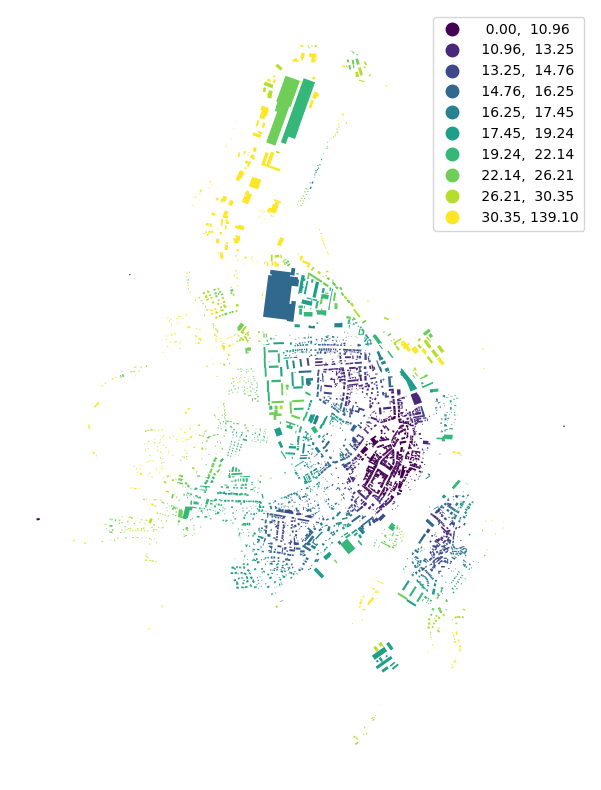

In [7]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(
    ax=ax,
    column="mean_ib_dist",
    scheme="quantiles",
    k=10,
    legend=True,
    cmap="viridis",
)
ax.set_axis_off()
plt.show()